In [1]:
# MOD 1: needed to append sys path to import holodeck
import sys
sys.path.append('C:/Users/emiga/OneDrive/Cal/GWs/code/holodeck')

# %load ./init.ipy
%reload_ext autoreload
%autoreload 2
from importlib import reload

import os
import sys
import logging
import warnings
import numpy as np
import astropy as ap
import scipy as sp
import scipy.stats
import matplotlib as mpl
import matplotlib.pyplot as plt

import h5py
import tqdm.notebook as tqdm

import kalepy as kale
# import kalepy.utils
import kalepy.plot

import holodeck as holo
import holodeck.sam
from holodeck import utils, plot, cosmo
from holodeck.constants import MSOL, PC, YR, MPC, GYR, SPLC

# Silence annoying numpy errors
np.seterr(divide='ignore', invalid='ignore', over='ignore')
warnings.filterwarnings("ignore", category=UserWarning)

# Plotting settings
mpl.rc('font', **{'family': 'serif', 'sans-serif': ['Times'], 'size': 15})
mpl.rc('lines', solid_capstyle='round')
mpl.rc('mathtext', fontset='cm')
mpl.style.use('default')   # avoid dark backgrounds from dark theme vscode
plt.rcParams.update({'grid.alpha': 0.5})

log = holo.log
log.setLevel(logging.INFO)

In [36]:
# Name my models so I can label them in plots


holo.sam.GSMF_Schechter.name = 'GSMF_Schechter'
holo.sam.GPF_Power_Law.name = 'GPF_Power_Law'                # Galaxy Pair Fraction (GPF)
holo.sam.GMT_Power_Law.name = 'GMT_Power_Law'                # Galaxy Merger Time   (GMT)
holo.relations.MMBulge_MM2013.name = 'MMBulge_MM2013'        # M-MBulge Relation    (MMB)

In [22]:
# default SAM model
gsmf=holo.sam.GSMF_Schechter()               # Galaxy Stellar-Mass Function (GSMF)
gpf=holo.sam.GPF_Power_Law()                 # Galaxy Pair Fraction (GPF)
gmt=holo.sam.GMT_Power_Law()                 # Galaxy Merger Time   (GMT)
mmbulge=holo.relations.MMBulge_MM2013()      # M-MBulge Relation    (MMB)
# mmbulge_standard = holo.relations.MMBulge_Standard()

#hard = holo.evolution.Hard_GW() ? 

# defaults, same as semi-analytic-models.ipynb
sam = holo.sam.Semi_Analytic_Model(gsmf=gsmf, gpf=gpf, gmt=gmt, mmbulge=mmbulge)


In [30]:
# Observered frequency bins and edges
fobs = utils.nyquist_freqs(10.0*YR, 0.2*YR)
fobs_edges = utils.nyquist_freqs_edges(10.0*YR, 0.2*YR)
print(f"Number of frequency bins: {fobs.size-1}")
print(f"  between [{fobs[0]*YR:.2f}, {fobs[-1]*YR:.2f}] 1/yr")
print(f"          [{fobs[0]*1e9:.2f}, {fobs[-1]*1e9:.2f}] nHz")

Number of frequency bins: 24
  between [0.10, 2.50] 1/yr
          [3.17, 79.22] nHz


In [31]:
# GWB for 5 realizations
# gwb = sam.gwb(fobs_edges, realize=5)
# # error: lam value too larger

In [32]:
# GWB continuous, without sampling
gwb = sam.gwb(fobs_edges, realize=False)

In [33]:
print('gwb shape:', gwb.shape)
print('gwb:', gwb)
print('fobs shape:', fobs.shape)
print('fobs:', fobs)
print('fobs_edges shape:', fobs_edges.shape)
print('fobs_edges:', fobs_edges)

gwb shape: (25,)
gwb: [4.55000343e-15 2.76410266e-15 2.09673675e-15 1.72724871e-15
 1.48708734e-15 1.31621299e-15 1.18730124e-15 1.08595725e-15
 1.00381002e-15 9.35629667e-16 8.77965383e-16 8.28440062e-16
 7.85358123e-16 7.47474733e-16 7.13853548e-16 6.83775536e-16
 6.56678587e-16 6.32116360e-16 6.09729544e-16 5.89225344e-16
 5.70362562e-16 5.52940550e-16 5.36790913e-16 5.21771186e-16
 5.04443420e-16]
fobs shape: (25,)
fobs: [3.16880878e-09 6.33761756e-09 9.50642634e-09 1.26752351e-08
 1.58440439e-08 1.90128527e-08 2.21816615e-08 2.53504703e-08
 2.85192790e-08 3.16880878e-08 3.48568966e-08 3.80257054e-08
 4.11945142e-08 4.43633229e-08 4.75321317e-08 5.07009405e-08
 5.38697493e-08 5.70385581e-08 6.02073668e-08 6.33761756e-08
 6.65449844e-08 6.97137932e-08 7.28826020e-08 7.60514108e-08
 7.92202195e-08]
fobs_edges shape: (26,)
fobs_edges: [1.58440439e-09 4.75321317e-09 7.92202195e-09 1.10908307e-08
 1.42596395e-08 1.74284483e-08 2.05972571e-08 2.37660659e-08
 2.69348746e-08 3.01036834e-08

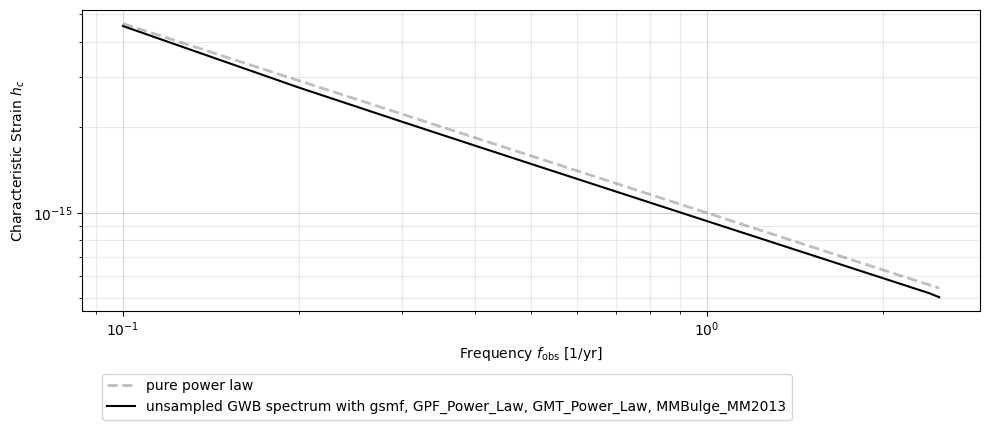

In [61]:
# Plot just this one realization
fig, ax = plot.figax(xlabel='Frequency $f_\mathrm{obs}$ [1/yr]', 
                    ylabel='Characteristic Strain $h_c$')

# `fobs` are bin centers in CGS units, convert to [1/yr]
xx = fobs * YR


# plot a reference, pure power-law  strain spectrum:   h_c(f) = 1e-15 * (f * yr) ^ -2/3
yy = 1e-15 * np.power(xx, -2.0/3.0)
ax.plot(xx, yy, 'k--', alpha=0.25, lw=2.0, label = 'pure power law')

# Plot the median GWB spectrum
# ax.plot(xx, np.median(gwb, axis=-1), 'k-', label='median GWB spectrum')
# this doesn't work without sampling

# try plotting the model without sampling
ax.plot(xx, gwb, 'k-', label='unsampled GWB spectrum with %s, %s, %s, %s' 
        % (sam._gsmf.name, sam._gpf.name, sam._gmt.name, sam._mmbulge.name))

ax.legend(bbox_to_anchor=(.1,-.08), bbox_transform=fig.transFigure, loc='lower left')
fig.tight_layout()
plt.show()

Phinney 2001 - GWB_ideal

In [68]:
"""Calculate the idealized, continuous GWB amplitude.
Calculation follows [Phinney2001]_ (Eq.5) or equivalently [Enoki+Nagashima-2007] (Eq.3.6).
This calculation assumes a smooth, continuous population of binaries that are purely GW driven.
* There are no finite-number effects.
* There are no environmental or non-GW driven evolution effects.
* There is no coalescence of binaries cutting them off at high-frequencies.
"""

gwb_ideal = sam.gwb_ideal(1.0/YR)
fobs_yr = 1.0/YR
fobs_yr = fobs_yr * (1.0 + np.array([-0.05, 0.05]))
ayr = sam.gwb(fobs_yr, realize=100)
print(gwb_ideal.shape)

<holodeck.sam.Semi_Analytic_Model object at 0x000001C51C94C8B0> :: utils.stats(rz)='-1.00e+00, -1.00e+00, -1.00e+00, 5.84e-02, 2.07e+00, 5.37e+00, 8.02e+00'
()


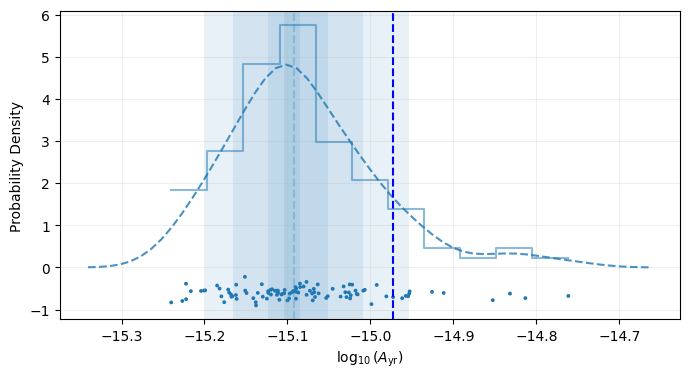

In [69]:
fig, ax = plt.subplots(figsize=[8, 4])
ax.set(xlabel=r'$\log_{10}(A_\mathrm{yr})$', ylabel='Probability Density')
ax.grid(alpha=0.2)

# use `kalepy` do draw the 1D distribution
kale.dist1d(np.log10(ayr), density=True, confidence=True)
ax.axvline(np.log10(gwb_ideal), ls='--', color='blue')


In [70]:
"""Calculate the idealized, continuous GWB amplitude.
Calculation follows [Phinney2001]_ (Eq.5) or equivalently [Enoki+Nagashima-2007] (Eq.3.6).
This calculation assumes a smooth, continuous population of binaries that are purely GW driven.
* There are no finite-number effects.
* There are no environmental or non-GW driven evolution effects.
* There is no coalescence of binaries cutting them off at high-frequencies.
"""

gwb_ideal = sam.gwb_ideal(10.0/YR)
fobs_yr = 10.0/YR
fobs_yr = fobs_yr * (1.0 + np.array([-0.05, 0.05]))
ayr = sam.gwb(fobs_yr, realize=100)
print(gwb_ideal.shape)

<holodeck.sam.Semi_Analytic_Model object at 0x000001C51C94C8B0> :: utils.stats(rz)='-1.00e+00, -1.00e+00, -1.00e+00, 5.84e-02, 2.07e+00, 5.37e+00, 8.02e+00'
()


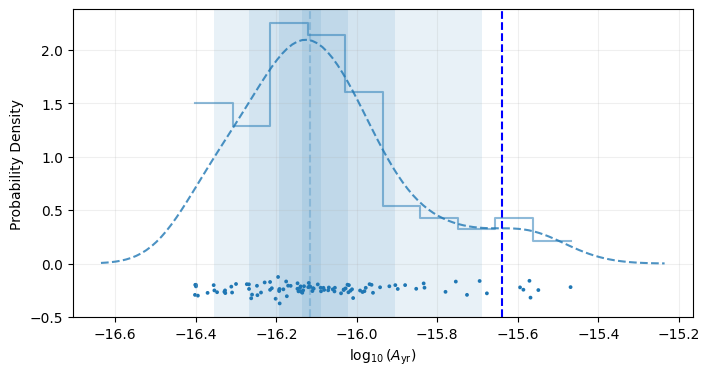

In [71]:
fig, ax = plt.subplots(figsize=[8, 4])
ax.set(xlabel=r'$\log_{10}(A_\mathrm{yr})$', ylabel='Probability Density')
ax.grid(alpha=0.2)

# use `kalepy` do draw the 1D distribution
kale.dist1d(np.log10(ayr), density=True, confidence=True)
ax.axvline(np.log10(gwb_ideal), ls='--', color='blue')


Below here I will try variations on sam with different gsmf, gpf, gmt, and mmb

In [ ]:
# Name my models so I can label them in plots


holo.sam.GSMF_Schechter.name = 'GSMF_Schechter'
holo.sam.GPF_Power_Law.name = 'GPF_Power_Law'                # Galaxy Pair Fraction (GPF)
holo.sam.GMT_Power_Law.name = 'GMT_Power_Law'                # Galaxy Merger Time   (GMT)
holo.relations.MMBulge_MM2013.name = 'MMBulge_MM2013'        # M-MBulge Relation    (MMB)

In [ ]:
# default SAM model
gsmf=holo.sam.GSMF_Schechter()               # Galaxy Stellar-Mass Function (GSMF)
gpf=holo.sam.GPF_Power_Law()                 # Galaxy Pair Fraction (GPF)
gmt=holo.sam.GMT_Power_Law()                 # Galaxy Merger Time   (GMT)
mmbulge=holo.relations.MMBulge_MM2013()      # M-MBulge Relation    (MMB)
# mmbulge_standard = holo.relations.MMBulge_Standard()

#hard = holo.evolution.Hard_GW() ? 

# defaults, same as semi-analytic-models.ipynb
sam = holo.sam.Semi_Analytic_Model(gsmf=gsmf, gpf=gpf, gmt=gmt, mmbulge=mmbulge)


Add some other models

In [ ]:
# Name my models so I can label them in plots


holo.sam.GSMF_Schechter.name = 'GSMF_Schechter'
holo.sam.GPF_Power_Law.name = 'GPF_Power_Law'                # Galaxy Pair Fraction (GPF)
holo.sam.GMT_Power_Law.name = 'GMT_Power_Law'                # Galaxy Merger Time   (GMT)
holo.relations.MMBulge_MM2013.name = 'MMBulge_MM2013'        # M-MBulge Relation    (MMB)

In [ ]:
# default SAM model
gsmf=holo.sam.GSMF_Schechter()               # Galaxy Stellar-Mass Function (GSMF)
gpf=holo.sam.GPF_Power_Law()                 # Galaxy Pair Fraction (GPF)
gmt=holo.sam.GMT_Power_Law()                 # Galaxy Merger Time   (GMT)
mmbulge=holo.relations.MMBulge_MM2013()      # M-MBulge Relation    (MMB)
# mmbulge_standard = holo.relations.MMBulge_Standard()

#hard = holo.evolution.Hard_GW() ? 

# defaults, same as semi-analytic-models.ipynb
sam = holo.sam.Semi_Analytic_Model(gsmf=gsmf, gpf=gpf, gmt=gmt, mmbulge=mmbulge)
